In [1]:
import os
import sys
import time
import numpy as np
from math import sqrt, atan2, asin, degrees, radians

# Build an absolute path from this notebook's parent directory
module_path = os.path.abspath(os.path.join('..', 'lib'))

# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)

# Now you can import the desired function or class
from interface import Visionbot 
from mpu9250_i2c import *
from quaternion import *

In [2]:
vBot = Visionbot()

In [3]:
def accel_fit(x_input,m_x,b):
    return (m_x*x_input)+b # fit equation for accel calibration

In [4]:
#raw data
accel_coeffs = [np.array([-1.00147049, -0.13395287]),
                np.array([ 0.99936757, -0.01591343]),
                np.array([-0.98202953, -0.05023495])]
mag_coeff = [10.0341796875, 21.09375,-14.2822265625]
gyro_coeff = [7.5194549560546875, -20.7506103515625, 1.5494155883789062]
   
ax,ay,az,gx,gy,gz = mpu6050_conv() # read and convert mpu6050 data
mx,my,mz = AK8963_conv() # read and convert AK8963 magnetometer data

#Correct bias/Apply calibration coefficients
ax_offseted = accel_fit(ax,*accel_coeffs[0])
ay_offseted = accel_fit(ay,*accel_coeffs[1])
az_offseted = accel_fit(az,*accel_coeffs[2])
    
rot_axis = 2 # axis being rotated (2 = z-axis)
gyro_offseted = np.array([gx, gy, gz]) - gyro_coeff

mx_offseted = mx - mag_coeff[0]
my_offseted = my - mag_coeff[1]
mz_offseted = mz - mag_coeff[2]


In [5]:
q = Quaternion()

In [6]:
q.update(np.array([ax_offseted, ay_offseted, az_offseted]),
         gyro_offseted,
         np.array([mx_offseted, my_offseted, mz_offseted]),
         time.perf_counter())
                  

In [7]:
q.pitch, q.roll, q.heading

(-0.001604076120931363, -0.0010480777250429128, -0.006551993215482428)

In [8]:
import numpy as np
import csv,datetime
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid as cumtrapz
from scipy import signal

def imu_bot_speed(dt_stop=2, m_speed =150):
    vBot = Visionbot()
    mpu_labels = ['a_x','a_y','a_z'] # 
    cal_size = 100 # number of points to use for calibration 
           
    accel_coeffs = [np.array([-1.00147049, -0.13395287]),
                np.array([ 0.99936757, -0.01591343]),
                np.array([-0.98202953, -0.05023495])]
    #############################
    # Main Loop to Integrate IMU
    #############################
    #
    data_indx = 1 # index of variable to integrate
    dt_stop = dt_stop # seconds to record and integrate
    
    plt.style.use('ggplot')
    plt.ion()
    fig,axs = plt.subplots(3,1,figsize=(12,9))

    accel_array,t_array = [],[]
    print("Starting Data Acquisition")
    [axs[ii].clear() for ii in range(0,3)]
    t0 = time.time()
    
    #Move bot Forward
    vBot.Ctrl_Drive(0,0,m_speed) #L2
    vBot.Ctrl_Drive(2,0,m_speed) #R2

    vBot.Ctrl_Drive(1,1,m_speed) #R1
    vBot.Ctrl_Drive(3,1,m_speed) #L1
    
    while time.time()-t0 < dt_stop:
        try:
            ax,ay,az,wx,wy,wz = mpu6050_conv() # read and convert mpu6050 data
            mx,my,mz = AK8963_conv() # read and convert AK8963 magnetometer data
            t_array.append(time.time()-t0)
            data_array = [ax,ay,az,wx,wy,wz,mx,my,mz]
            accel_array.append(accel_fit(data_array[data_indx],
                                             *accel_coeffs[data_indx]))
        except:
            continue

    #Stop bot
    vBot.Ctrl_Drive(0,0,0)
    vBot.Ctrl_Drive(1,0,0)
    vBot.Ctrl_Drive(2,0,0)
    vBot.Ctrl_Drive(3,0,0)
    
    #
    ##################################
    # Signal Filtering
     ##################################
    #
    Fs_approx = len(accel_array)/dt_stop
    b_filt,a_filt = signal.butter(4,5,'low',fs=Fs_approx)
    accel_array = signal.filtfilt(b_filt,a_filt,accel_array)
    accel_array = np.multiply(accel_array,9.80665)
    #
        ##################################
        # Print Sample Rate and Accel
        # Integration Value
        ##################################
        #
    print("Sample Rate: {0:2.0f}Hz".format(len(accel_array)/dt_stop))
    veloc_array = np.append(0.0,cumtrapz(accel_array,x=t_array))
    dist_approx = np.trapz(veloc_array,x=t_array)
    dist_array = np.append(0.0,cumtrapz(veloc_array,x=t_array))
    print("Displace in y-dir: {0:2.2f}m".format(dist_approx))
    axs[0].plot(t_array,accel_array,label="$"+mpu_labels[data_indx]+"$",
                    color=plt.cm.Set1(0),linewidth=2.5)
    axs[1].plot(t_array,veloc_array,
                    label="$v_"+mpu_labels[data_indx].split("_")[1]+"$",
                    color=plt.cm.Set1(1),linewidth=2.5)
    axs[2].plot(t_array,dist_array,
                    label="$d_"+mpu_labels[data_indx].split("_")[1]+"$",
                    color=plt.cm.Set1(2),linewidth=2.5)
    [axs[ii].legend() for ii in range(0,len(axs))]
    axs[0].set_ylabel('Acceleration [m$\cdot$s$^{-2}$]',fontsize=16)
    axs[1].set_ylabel('Velocity [m$\cdot$s$^{-1}$]',fontsize=16)
    axs[2].set_ylabel('Displacement [m]',fontsize=16)
    axs[2].set_xlabel('Time [s]',fontsize=18)
    axs[0].set_title("MPU9250 Accelerometer Integration",fontsize=18)
    plt.pause(0.01)
    plt.savefig("accel_veloc_displace_integration.png",dpi=300,
                    bbox_inches='tight',facecolor="#FCFCFC")

    del vBot

<>:84: SyntaxWarning: invalid escape sequence '\c'
<>:85: SyntaxWarning: invalid escape sequence '\c'
<>:84: SyntaxWarning: invalid escape sequence '\c'
<>:85: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2443/3756828403.py:84: SyntaxWarning: invalid escape sequence '\c'
  axs[0].set_ylabel('Acceleration [m$\cdot$s$^{-2}$]',fontsize=16)
/tmp/ipykernel_2443/3756828403.py:85: SyntaxWarning: invalid escape sequence '\c'
  axs[1].set_ylabel('Velocity [m$\cdot$s$^{-1}$]',fontsize=16)


Starting Data Acquisition
Sample Rate: 125Hz
Displace in y-dir: 0.05m


/tmp/ipykernel_2073/3208328118.py:71: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  dist_approx = np.trapz(veloc_array,x=t_array)


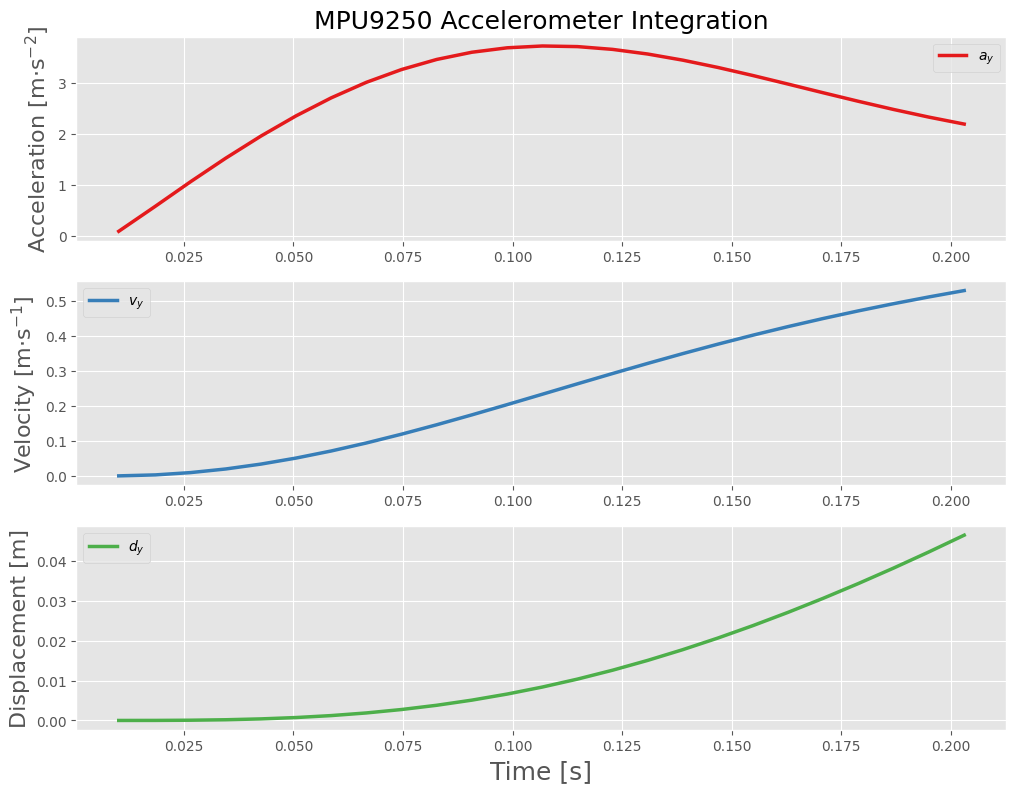

<Figure size 640x480 with 0 Axes>

In [40]:
imu_bot_speed(.2, 180)

In [63]:
import time,math

m_speed = 60
turn = 60

#Move bot Forward
vBot.Ctrl_Drive(1,1,m_speed) #R1
vBot.Ctrl_Drive(2,0,m_speed) #R2

vBot.Ctrl_Drive(3,1,m_speed) #L1
vBot.Ctrl_Drive(0,0,m_speed) #L2
time.sleep(3)


#move bot left
rad2deg = math.pi / 180
vx = m_speed * math.cos(turn * rad2deg)
vy = m_speed * math.sin(turn * rad2deg)

l2 = int(vy + vx) 
l1 = int(vy + vx)
r2 = int((vy + vx)*.75)
r1 = int((vy + vx)*.75)

#Move bot Forward
vBot.Ctrl_Drive(1,1,r1) #R1
vBot.Ctrl_Drive(2,0, r2) #R2

vBot.Ctrl_Drive(3,1,l1) #L1
vBot.Ctrl_Drive(0,0,l2) #L2

time.sleep(2)

#Stop bot
vBot.Ctrl_Drive(0,0,0)
vBot.Ctrl_Drive(1,0,0)
vBot.Ctrl_Drive(2,0,0)
vBot.Ctrl_Drive(3,0,0)


In [83]:
def move_bot(m_speed=90, turn=90):
    rad2deg = math.pi / 180
    l1 = l2 = r1 = r2 = m_speed 
    if( turn > 90):
        #move bot right
        vx = m_speed * math.cos(60 * rad2deg)
        vy = m_speed * math.sin(60 * rad2deg)
        l2 = int(vy + vx) 
        l1 = int(vy + vx)
        r2 = int((vy + vx)*.75)
        r1 = int((vy + vx)*.75)
    elif (turn > 90):
    #move bot left
        vx = m_speed * math.cos((120 -90) * rad2deg)
        vy = m_speed * math.sin((120 -90) * rad2deg)
        r1 = int(vy + vx) 
        r2 = int(vy + vx)
        l1 = int((vy + vx)*.75)
        l2 = int((vy + vx)*.75)
    else:
        l1 = l2 = r1 = r2 = m_speed 
    
    return l1, l2, r1, r2

def stop_bot():
    #Stop bot
    vBot.Ctrl_Drive(0,0,0)
    vBot.Ctrl_Drive(1,0,0)
    vBot.Ctrl_Drive(2,0,0)
    vBot.Ctrl_Drive(3,0,0)

In [84]:
move_bot()

(90, 90, 90, 90)

In [95]:
t0 = time.time()
l1, l2, r1, r2 = move_bot()
while time.time()- t0 < 3:
    try: 
        vBot.Ctrl_Drive(1,1,r1) #R1
        vBot.Ctrl_Drive(2,0, r2) #R2
        vBot.Ctrl_Drive(3,1,l1) #L1
        vBot.Ctrl_Drive(0,0,l2) #L2
        if (time.time()- t0 > 1 and time.time()- t0 < 2):
            l1, l2, r1, r2 = move_bot(turn=120)
        else:
            l1, l2, r1, r2 = move_bot()
    except:
        stop_bot()
        continue
stop_bot()